# MIMIC-III

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyemb as eb


Here, we demonstrate functionality related to multipartite graphs [Modell et al., 2022](https://arxiv.org/abs/2202.03945) -- a natural way to explore relational databases. We use [MIMIC-III](https://physionet.org/content/mimiciii/1.4/) which is a relational database of heath-related data of patients at critical care units of a medical center between 2001-2012. 

Unlike the other examples, the data cannot be shared directly. Users can apply for access to the database [here](https://mimic.mit.edu/docs/gettingstarted/) and a smaller open access version can be found [here](https://physionet.org/content/mimiciii-demo/1.4/).

The files we use here are: `ADMISSIONS.csv`, `LABEVENTS.csv`, `MICROBIOLOGY.csv` and `PRESCRIPTIONS.csv`. These files all contain the associated hospital admission ID (`HADM_ID`) which we use to create a network. Within the admissions file, all the hospital admissions have a diagnosis associated with them which we use as labels. 

### Data load

In [2]:
joining_col = 'HADM_ID'
data_names = ['micro', 'lab', 'pre']
dfs = {name: pd.read_csv('data/' + name + '.csv') for name in data_names}

/tmp/ipykernel_38409/1342678660.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = {name: pd.read_csv('data/' + name + '.csv') for name in data_names}


Create a dictionary of hospital admission IDs to diagnoses. 

In [3]:
adm = pd.read_csv('data/adm.csv')
hadm_to_diag = dict(zip(adm[joining_col], adm['DIAGNOSIS']))
hadm_to_diag = {str(k): v for k, v in hadm_to_diag.items()}

Create a multipartite graph where we have links between hospital admission IDs and organism IDs, lab items and drugs.

This creates a a large matrix where each unique entity in each parition has a row and a column. 

In [4]:
pairs = [[joining_col, 'ORG_ITEMID'], [joining_col,
                                       'ITEMID'], [joining_col, 'FORMULARY_DRUG_CD']]

A, attributes = eb.graph_from_dataframes(list(dfs.values()), pairs)

3it [00:03,  1.18s/it]


To create the matrix with hospital admissions as the rows and organism, lab and drug IDs as the columns, we use the `find_subgraph` functions. 

This takes in a list (of two lists), the first containing the attributes of items we want in the rows, here we want partition `HADM_ID`, and the second we have the attributes we want in the columns, that is the partitions `ORG_ITEMID`, `FORMULARY_DRUG_CD` and `ITEMID`.

In [5]:
sub_attr = [
    [{'partition': joining_col}],
    [{'partition': 'ORG_ITEMID'}, {'partition': 'ITEMID'},
        {'partition': 'FORMULARY_DRUG_CD'}]
]
subgraph_A, subgraph_attributes = eb.find_subgraph(A, attributes, sub_attr)

In [6]:
print('Number of rows:', subgraph_A.shape[0])

Number of rows: 57709


For computational reasons we calculate the dimension on a sample of the data.

In [ ]:
n = 10000  
random_rows = np.random.choice(subgraph_A.shape[0], n, replace=False) 
sample_subgraph_A = subgraph_A[random_rows, :]

Y = eb.embed(sample_subgraph_A, d=100, version='full')
ws, dim = eb.wasserstein_dimension_select(Y, range(50), split=0.5)
print("Selected dimension: {}".format(dim))

In [8]:
le = eb.embed(subgraph_A, dim, make_laplacian=True, regulariser= 'auto')s

Perform tSNE

In [9]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsne = tsne.fit_transform(le)

Next, we can see if the tSNE plot shows any clustering related to the diagnoses. The labels are quite messy, with over 3000 unique diagnoses, so instead we colour based on whether a diagnosis contains one of the following words: withdrawal, hemorrhage, coronary, leukemia or newborn. 

These points will be coloured according to `labels_to_colour`, all others are grey.

In [10]:
split_labels = [subgraph_attributes[0][i]['name'].split('::')[1] for i in range(subgraph_A.shape[0])]
labels = [str(hadm_to_diag[a]) for a in split_labels]
labels_to_colour = {'WITHDRAWAL': 'gold', 'MYOCARDIAL': 'lightpink', 'HEMORRHAGE': 'firebrick', 'CORONARY': 'powderblue', 'LEUKEMIA': 'lime', 'NEWBORN': 'coral', 'OTHER': 'darkgrey'}

keywords = list(labels_to_colour.keys())
plot_labels  = [
    next((keyword for keyword in keywords if keyword in label), None)
    if any(keyword in label for keyword in keywords) else 'OTHER'
    for label in labels]
plot_colours = [labels_to_colour[label] for label in plot_labels]

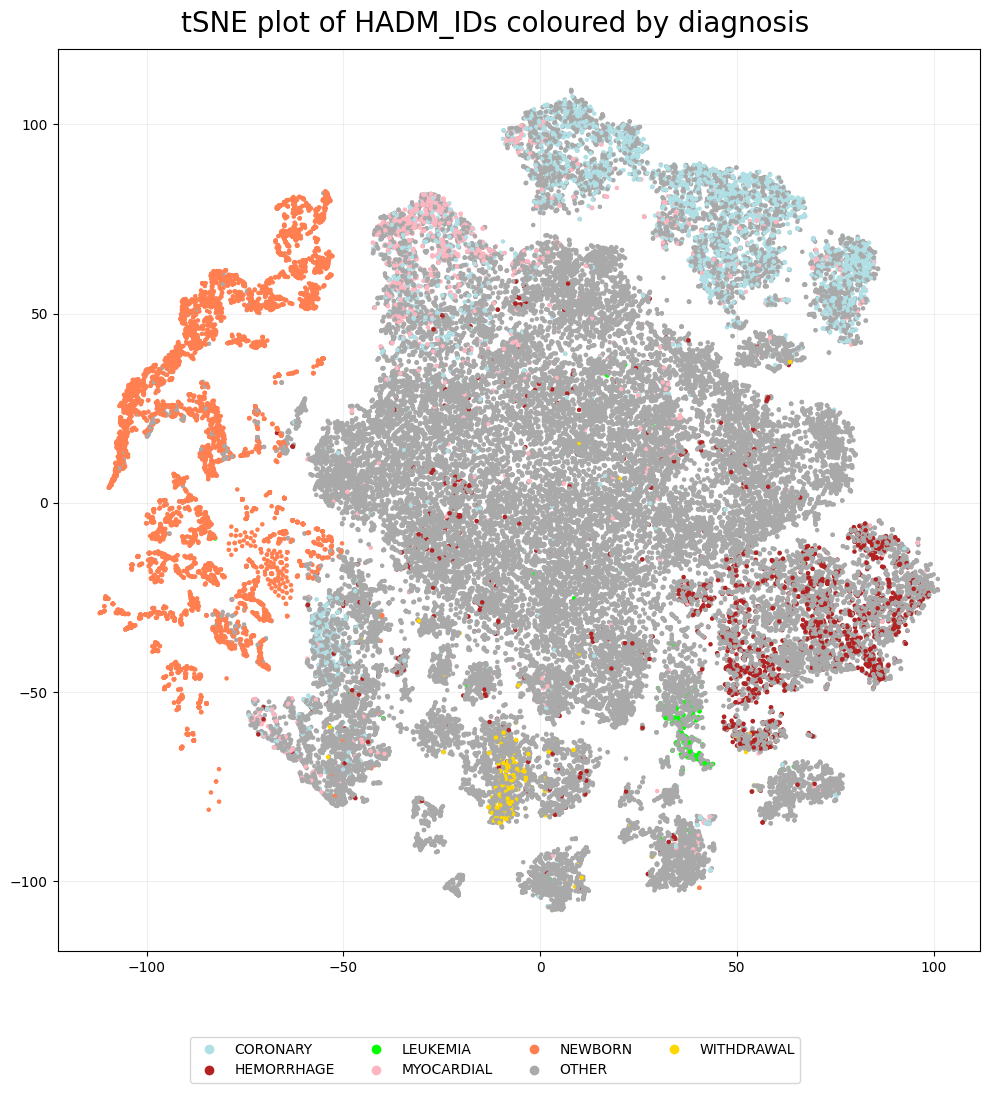

In [13]:
pca_fig = eb.snapshot_plot(
    embedding = tsne, 
    node_labels = plot_labels, 
    c = plot_colours,
    tick_labels = True,
    add_legend = True, 
    title = 'tSNE plot of HADM_IDs coloured by diagnosis',
    # Apply other matplotlib settings
    figsize = (10, 10),
    s=5,
)
plt.tight_layout()

Therefore, it is clear we see some clustering based on diagnosis. It is worth noting that while coronary and myocardial have quite a large overlap, these words both relate to problems with the heart.

# References

* Modell, A., Gallagher, I., Cape, J. and Rubin-Delanchy, P., 2022. Spectral embedding and the latent geometry of multipartite networks. arXiv preprint arXiv:2202.03945.